# This practice will cover learning points in Topic 2
### 1 - Fit MLR model in python with sklearn and statesmodel packages
### 2 - Model Selection
### 3 - Weighted regression
### 4 - Regularization, L1 and L2

Import required Python packages.

In [ ]:
# if you haven't installed statsmodels
! pip install statsmodels dmba

In [3]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

%matplotlib inline

no display found. Using non-interactive Agg backend


Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
DATA = Path('.').resolve().parents[1] / 'IntermediateLevel/DataScienceProgram/Class2/Practice/mlr'

HOUSE_CSV = DATA / 'house_sales.csv'

In [3]:
# print(DATA)
# print(HOUSE_CSV)

#### Data read and train-test split

In [4]:
houseall = pd.read_csv(HOUSE_CSV, sep='\t')

house, house_test = train_test_split(houseall, test_size=0.2)

print(house.head())
print(house.shape)

print(house_test.head())
print(house_test.shape)

      DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
10533   2007-03-10     489201  3278603970  Single Family  2007-03-01   429600   
25462   2006-12-27     316250  9284801095  Single Family  2006-12-01   423400   
11887   2006-01-05     758000  3592500971  Single Family  2006-01-01   383200   
11120   2007-01-25     284000  3353401093  Single Family  2007-01-01   425600   
7404    2012-09-25     690000  2426059124  Single Family  2012-09-01   329600   

       zhvi_idx  AdjSalePrice  NbrLivingUnits  SqFtLot  ...  Bathrooms  \
10533  0.987132      495578.0               1     2722  ...       2.25   
25462  0.972886      325064.0               1     5750  ...       2.00   
11887  0.880515      860860.0               1     2944  ...       1.50   
11120  0.977941      290406.0               1    12000  ...       2.00   
7404   0.757353      911068.0               1    47480  ...       3.25   

       Bedrooms  BldgGrade  YrBuilt  YrRenovated  TrafficNoise  Land

We can use the `LinearRegression` model from _scikit-learn_.

## 1 - Multiple Linear Regression (SKlearn)

In [5]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

print(house[subset].head())

       AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
10533      495578.0           1600     2722       2.25         2          7
25462      325064.0           1350     5750       2.00         4          7
11887      860860.0           2190     2944       1.50         3          9
11120      290406.0           1360    12000       2.00         3          7
7404       911068.0           4160    47480       3.25         4         10


In [6]:
print(house.head())
print(house.columns)

      DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
10533   2007-03-10     489201  3278603970  Single Family  2007-03-01   429600   
25462   2006-12-27     316250  9284801095  Single Family  2006-12-01   423400   
11887   2006-01-05     758000  3592500971  Single Family  2006-01-01   383200   
11120   2007-01-25     284000  3353401093  Single Family  2007-01-01   425600   
7404    2012-09-25     690000  2426059124  Single Family  2012-09-01   329600   

       zhvi_idx  AdjSalePrice  NbrLivingUnits  SqFtLot  ...  Bathrooms  \
10533  0.987132      495578.0               1     2722  ...       2.25   
25462  0.972886      325064.0               1     5750  ...       2.00   
11887  0.880515      860860.0               1     2944  ...       1.50   
11120  0.977941      290406.0               1    12000  ...       2.00   
7404   0.757353      911068.0               1    47480  ...       3.25   

       Bedrooms  BldgGrade  YrBuilt  YrRenovated  TrafficNoise  Land

In [7]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -537292.342
Coefficients:
 SqFtTotLiving: 225.81655434699528
 SqFtLot: -0.016911652676232958
 Bathrooms: -15176.214094097379
 Bedrooms: -51016.63096341433
 BldgGrade: 109131.77720832141


### Assessing the Model with performance KPIs
_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score` and `RMSE`.

In [8]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

fitted_test = house_lm.predict(house_test[predictors])
RMSE_test = np.sqrt(mean_squared_error(house_test[outcome], fitted_test))
r2_test = r2_score(house_test[outcome], fitted_test)
print(f'RMSE_test: {RMSE_test:.0f}')
print(f'r2_test: {r2_test:.4f}')

RMSE: 263601
r2: 0.5400
RMSE_test: 263601
r2_test: 0.5426


## 1 - Multiple Linear Regression (statsmodels)

While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

In [9]:
mlr_sm = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = mlr_sm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     4259.
Date:                Mon, 25 May 2020   Prob (F-statistic):               0.00
Time:                        18:14:39   Log-Likelihood:            -2.5229e+05
No. Observations:               18149   AIC:                         5.046e+05
Df Residuals:                   18143   BIC:                         5.046e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   225.8166      4.444     50.814

### Correlations between predictors

Correlation Matrix 
                SqFtTotLiving   SqFtLot  Bathrooms  Bedrooms  BldgGrade
SqFtTotLiving       1.000000  0.190555   0.767320  0.620581   0.771330
SqFtLot             0.190555  1.000000   0.103067  0.069024   0.144039
Bathrooms           0.767320  0.103067   1.000000  0.556512   0.661531
Bedrooms            0.620581  0.069024   0.556512  1.000000   0.381189
BldgGrade           0.771330  0.144039   0.661531  0.381189   1.000000


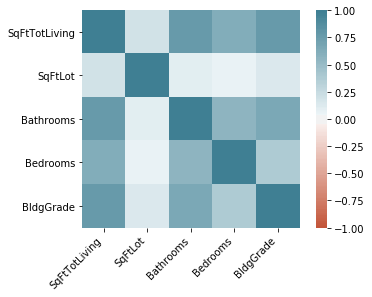

In [10]:
corr = house[predictors].corr()
print("Correlation Matrix \n {}".format(corr))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## 2 - Model Selection and Stepwise Regression

In [11]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

print("\nPredictors after nominal varibale(s) treatment: {} \n\n".format(X.shape))

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

       SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade   PropertyType  \
10533           1600     2722       2.25         2          7  Single Family   
25462           1350     5750       2.00         4          7  Single Family   
11887           2190     2944       1.50         3          9  Single Family   
11120           1360    12000       2.00         3          7  Single Family   
7404            4160    47480       3.25         4         10  Single Family   

       NbrLivingUnits  SqFtFinBasement  YrBuilt  YrRenovated  NewConstruction  
10533               1                0     2006            0             True  
25462               1                0     1981            0            False  
11887               1              450     1924            0            False  
11120               1                0     1979            0            False  
7404                1                0     1995            0            False  

 PropertyType List 
Single Family    1

We can use the `stepwise_selection` method from the _dmba_ package.

In [12]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=518678.88, constant
Step: score=506809.38, add SqFtTotLiving
Step: score=504941.39, add BldgGrade
Step: score=502853.23, add YrBuilt
Step: score=502498.79, add Bedrooms
Step: score=502317.45, add Bathrooms
Step: score=502266.50, add PropertyType_Townhouse
Step: score=502264.34, add SqFtLot
Step: score=502263.57, add NbrLivingUnits
Step: score=502263.57, unchanged None

Intercept: 6455514.035
Coefficients:
 SqFtTotLiving: 195.71554227514596
 BldgGrade: 140459.8698731352
 YrBuilt: -3696.073836472584
 Bedrooms: -55194.72668004559
 Bathrooms: 50368.02121183089
 PropertyType_Townhouse: 59973.385947772804
 SqFtLot: 0.13172564416718324
 NbrLivingUnits: -20001.16649589833


## 3 - Weighted regression
For the house data recent sale price is more relavent for future prediction, old sale data is less reliable, therefore, we like to emphasis the recent sale data by apply more weight. We will use year the house sale to 2005 as weight.

We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [13]:
print("\nDocumentDate List \n{}".format(house['DocumentDate'].value_counts(dropna=False)))


DocumentDate List 
2006-07-26    47
2006-06-19    44
2006-06-14    43
2006-07-18    42
2006-05-01    41
              ..
2010-08-21     1
2013-01-14     1
2010-12-19     1
2006-02-18     1
2010-12-22     1
Name: DocumentDate, Length: 2465, dtype: int64


In [14]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]  #list comprehension
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))  # apply()
house['Weight'] = house.Year - 2005

/Users/yibin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yibin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yibin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [15]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)

,predictor,house_lm,house_wt
0,SqFtTotLiving,225.816554,240.913546
1,SqFtLot,-0.016912,-0.150278
2,Bathrooms,-15176.214094,-25937.841355
3,Bedrooms,-51016.630963,-54764.750332
4,BldgGrade,109131.777208,119545.068021
5,intercept,-537292.341505,-607098.244372


       abs_residual_lm  abs_residual_wt  Year
10533     43867.191248     48697.793949  2007
25462     28097.746723     41912.261275  2006
11887     97292.094547     68095.396721  2006
11120     59729.351955     48980.389653  2007
7404     328162.111734    368992.621935  2012


Year   Abs_residual_lm    Abs_residual_wt
2006 142146.43105157308 147628.15901069436
2007 148850.15421396532 153238.17328783948
2008 142607.4236078624 146525.93056700155
2009 144326.80334668572 148230.63166698866
2010 164703.01217686944 167860.36779065046
2011 166876.51747634498 169913.22407987464
2012 168235.42282019847 170365.50573923826
2013 203138.83365696864 205992.08931926044
2014 184906.3273209374 186633.50733063632
2015 169975.70679862463 168306.36868563242


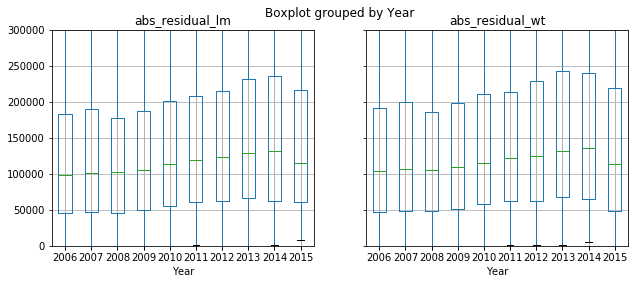

In [17]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)

print("\n\nYear   Abs_residual_lm    Abs_residual_wt")
for year, group in residuals.groupby('Year'):
    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

Seems only help 2015 prediction reduce the residuale.If we have a recent holdout sample we can test the weight could help for future prediction or not

# 4 - Regularization

In [18]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

outcome = 'AdjSalePrice'

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X_train = pd.get_dummies(house[predictors], drop_first=True)
X_train['NewConstruction'] = [1 if nc else 0 for nc in X_train['NewConstruction']]
y_train = house[outcome]

X_test = pd.get_dummies(house_test[predictors], drop_first=True)
X_test['NewConstruction'] = [1 if nc else 0 for nc in X_test['NewConstruction']]
y_test = house_test[outcome]

       SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade   PropertyType  \
10533           1600     2722       2.25         2          7  Single Family   
25462           1350     5750       2.00         4          7  Single Family   
11887           2190     2944       1.50         3          9  Single Family   
11120           1360    12000       2.00         3          7  Single Family   
7404            4160    47480       3.25         4         10  Single Family   

       NbrLivingUnits  SqFtFinBasement  YrBuilt  YrRenovated  NewConstruction  
10533               1                0     2006            0             True  
25462               1                0     1981            0            False  
11887               1              450     1924            0            False  
11120               1                0     1979            0            False  
7404                1                0     1995            0            False  

 PropertyType List 
Single Family    1

### Regular Multiple Regression

In [19]:
house_lm = LinearRegression()
house_lm.fit(X_train, y_train)

mlr_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((house_lm.intercept_, house_lm.coef_), 
                                axis=None), 3))
)

mlr_coefs

{'Intercept': 6420325.061,
 'SqFtTotLiving': 193.552,
 'SqFtLot': 0.136,
 'Bathrooms': 50307.759,
 'Bedrooms': -55397.312,
 'BldgGrade': 141274.485,
 'NbrLivingUnits': -25002.032,
 'SqFtFinBasement': 6.443,
 'YrBuilt': -3671.569,
 'YrRenovated': -2.12,
 'NewConstruction': 278.657,
 'PropertyType_Single Family': -10714.119}

In [20]:
fitted_test = house_lm.predict(X_test)
MSE_test = np.sqrt(mean_squared_error(y_test, fitted_test))
r2 = r2_score(y_test, fitted_test)
print(f'regular mlr MSE: {MSE_test:.0f}')
print(f'r2_test: {r2:.4f}')

regular mlr MSE: 238712
r2_test: 0.5885


### L2 - Ridge regression (Parameter shrinkage)

In [21]:
ridge_cv = RidgeCV(normalize=True, alphas=np.logspace(-10, 1, 400))
ridge_model = ridge_cv.fit(X_train, y_train)
ridge_prediction = ridge_model.predict(X_test)
ridge_mae = np.mean(np.abs(y_test - ridge_prediction))
ridge_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((ridge_model.intercept_, ridge_model.coef_), 
                                axis=None), 3))
)

print('Ridge Regression MAE: {}'.format(np.round(ridge_mae, 3)))
print('Ridge Regression coefficients:')
ridge_coefs

Ridge Regression MAE: 138247.612
Ridge Regression coefficients:


{'Intercept': 6316005.942,
 'SqFtTotLiving': 190.417,
 'SqFtLot': 0.144,
 'Bathrooms': 51040.744,
 'Bedrooms': -54178.926,
 'BldgGrade': 141014.125,
 'NbrLivingUnits': -25702.801,
 'SqFtFinBasement': 8.547,
 'YrBuilt': -3616.321,
 'YrRenovated': -1.268,
 'NewConstruction': 178.346,
 'PropertyType_Single Family': -12346.25}

### L1 - Lasso regression (Parameter sparsity)

In [22]:
lasso_cv = LassoCV(normalize=True, alphas=np.logspace(-10, 1, 400))
lasso_model = lasso_cv.fit(X_train, y_train)
lasso_prediction = lasso_model.predict(X_test)
lasso_mae = np.mean(np.abs(y_test - lasso_prediction))
lasso_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((lasso_model.intercept_, lasso_model.coef_), axis=None), 3))
)

print('LASSO MAE: {}'.format(np.round(lasso_mae, 3)))
print('LASSO coefficients:')
lasso_coefs

LASSO MAE: 138188.618
LASSO coefficients:


{'Intercept': 6263712.595,
 'SqFtTotLiving': 192.268,
 'SqFtLot': 0.116,
 'Bathrooms': 48323.958,
 'Bedrooms': -53737.993,
 'BldgGrade': 141226.119,
 'NbrLivingUnits': -14734.723,
 'SqFtFinBasement': 6.496,
 'YrBuilt': -3601.736,
 'YrRenovated': -0.0,
 'NewConstruction': 0.0,
 'PropertyType_Single Family': -0.0}

# Home Work

1. Compare the three model fits and draw conclusion 
from the comparision of the three model fit regarding there coefficent difference

2. Show the three model performance on both tran and test

In [27]:
model_coefs = pd.DataFrame.from_dict([mlr_coefs, ridge_coefs, lasso_coefs])
model_coefs['Model'] = ['MLR', 'RidgeRegression', 'LassoRegression']
model_coefs.set_index(['Model'])

,Intercept,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction,PropertyType_Single Family
Model,,,,,,,,,,,,
MLR,6420325.061,193.552,0.136,50307.759,-55397.312,141274.485,-25002.032,6.443,-3671.569,-2.120,278.657,-10714.119
RidgeRegression,6316005.942,190.417,0.144,51040.744,-54178.926,141014.125,-25702.801,8.547,-3616.321,-1.268,178.346,-12346.250
LassoRegression,6263712.595,192.268,0.116,48323.958,-53737.993,141226.119,-14734.723,6.496,-3601.736,-0.000,0.000,-0.000
